In [1]:
%matplotlib inline

In this notebook, we'll run through a brief example of how to model a full hot jupiter light curve -- including the transit, secondary eclipse, and phase curve -- using the machinery of the `exoplanet` package.

Let's begin with our custom imports. Note that we want to run `starry` in `lazy` mode (the default), since we need to be able to compute analytic derivatives of the model for use in `pymc3`.

In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet

starry.config.quiet = True
np.random.seed(1)

## Generating a dataset

Let's generate some synthetic data. First we create a star...

In [7]:
A = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
u1 = 0.646
u2 = 0.048
A.map[1] = u1
A.map[2] = u2

... and now we instantiate the planet...

In [8]:
# These are the parameters we're going to try to infer
log_amp_true = -3.0
offset_true = 30.0
mass_p = 7.0257708e-5
rp = 0.039974684
period = 4.888

b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp_true),
    m=mass_p,  # mass in solar masses
    r=rp,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=period,  # orbital period in days
    prot=1,
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
)
b.map[1, 0] = 0.5
b.theta0 = 180.0 + offset_true

In [9]:
sys = starry.System(A, b)

We can now generate a synthetic light curve, and add some noise:

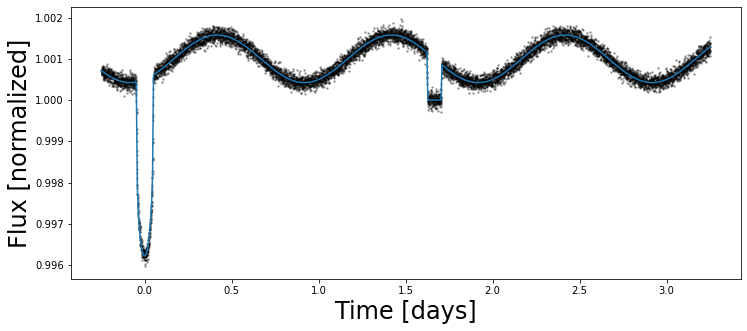

In [10]:
t = np.linspace(-0.25, 3.25, 10000)
flux_true = sys.flux(t).eval()
ferr = 1e-4
flux = flux_true + ferr * np.random.randn(len(t))
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, flux_true)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

## Fitting the data

We're going to fit this light curve using `exoplanet` and `pymc3`. Let's begin fresh and define a new star, planet, and system, this time *within a pymc3 model context*:

In [14]:
0.048+0.016

0.064

In [15]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)
    log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)
    u1 = pm.Uniform("u1", lower=0.638,upper=0.654)
    u2 = pm.Uniform("u2", lower=0.033,upper=0.064) 
    rp = pm.Uniform("rp", lower=0.03232321,upper=0.04632)
    mass_p = pm.Uniform("mp", lower=7.0000e-5,upper=7.5e-5) 
    period = pm.Uniform("porb", lower=2,upper=6)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0
    )
    A.map[1] = u1
    A.map[2] = u2

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp, inc=90.0, obl=0.0),
        m=mass_p,  # mass in solar masses
        r=rp,  # radius in solar radii
        inc=88.99, # orbital inclination
        porb=period,  # orbital period in days
        prot=1,
        w=-162.149,  # Argument of periastron (little omega)
        ecc=0.265,  # eccentricity
        Omega=106,
    )
    b.map[1, 0] = 0.5
    b.theta0 = 180.0 + offset

    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(t))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=ferr, observed=flux)

Great! The first thing we usually do is run this model through an optimizer (which is usually fast, since `starry` computes derivatives):

In [16]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x18aefa3b0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x18aefa3b0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [porb, mp, rp, u2, u1, log_amp, offset]


message: Desired error not necessarily achieved due to precision loss.
logp: -336188.2240994827 -> 53673.482014440175


Here's what our best model looks like:

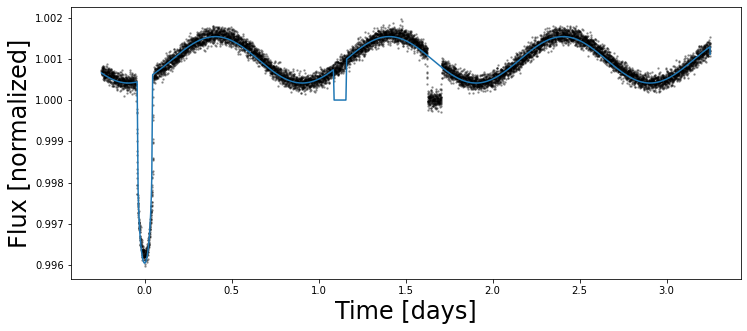

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

And here are the best-fit values of the two parameters:

In [19]:
print("offset:", map_soln["offset"])
print("log_amp:", map_soln["log_amp"])
print('mass_p', map_soln["mp"])
print('rp', map_soln["rp"])
print('u1', map_soln["u1"])
print('u2', map_soln["u2"])

offset: 34.38453612014185
log_amp: -3.010818979866443
mass_p 7.238049812125427e-05
rp 0.040703282797242966
u1 0.6381122629406416
u2 0.03315145438752607


Not bad! If we just cared about finding the best solution, we'd be done, but we actually want posteriors over the model parameters. For this, we're going to do sampling with `pymc3`:

In [20]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x18aefa3b0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x18aefa3b0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object inste

Sampling 4 chains for 250 tune and 500 draw iterations (1_000 + 2_000 draws total) took 2260 seconds.
The number of effective samples is smaller than 25% for some parameters.


And we're done! It's usually a good idea to look at a summary of the sampling procedure:

The `mc_errors` are relatively small, the `Rhat` convergence criterion is close to 1, and the number of effective samples `n_eff` is over 1000, all of which are good. We should probably run the sampler a bit longer, but this should be good enough for demonstration purposes. Let's plot our posterior distributions:

TypeError: TensorType does not support iteration. Maybe you are using builtins.sum instead of theano.tensor.sum? (Maybe .max?)

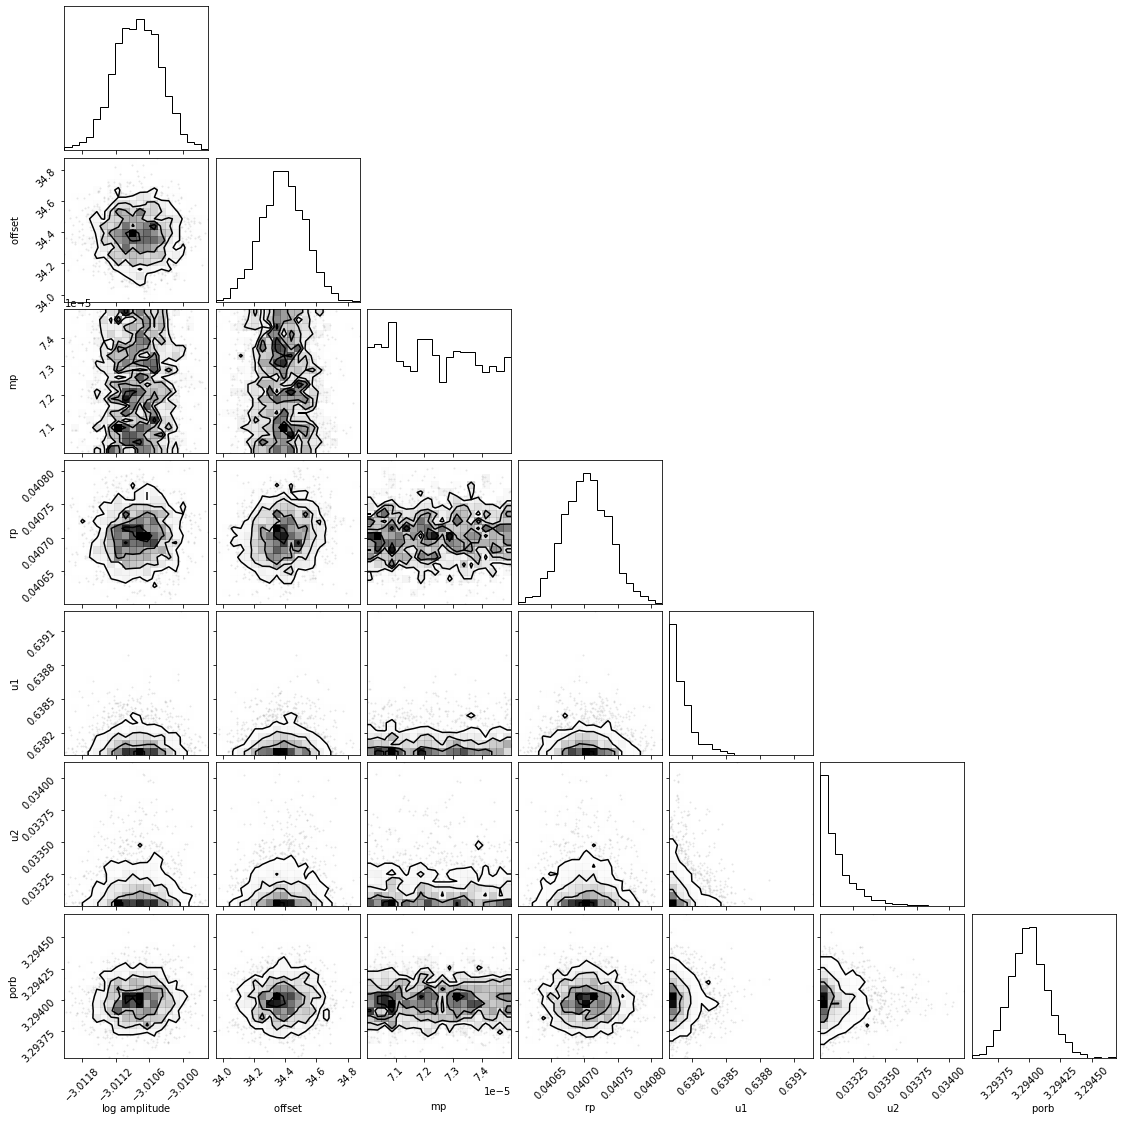

In [22]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["log_amp", "offset", "mp", "rp", "u1", "u2", "porb"])
corner.corner(
    np.array(samples),
    truths=[log_amp_true, offset_true, mass_p, rp, u1, u2, period],
    labels=[r"$\log\,\mathrm{amplitude}$", r"$\mathrm{offset}$", r"$\mathrm{mp}$", r"$\mathrm{rp}$", r"$\mathrm{u1}$", r"$\mathrm{u2}$", r"$\mathrm{porb}$"],
);

Looks great! The blue lines indicate the true values.